In [25]:
import random
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\Alexey\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling

In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1

    return input_image, input_mask


@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint["image"], (128, 128))
    input_mask = tf.image.resize(datapoint["segmentation_mask"], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint["image"], (128, 128))
    input_mask = tf.image.resize(datapoint["segmentation_mask"], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset["test"].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)

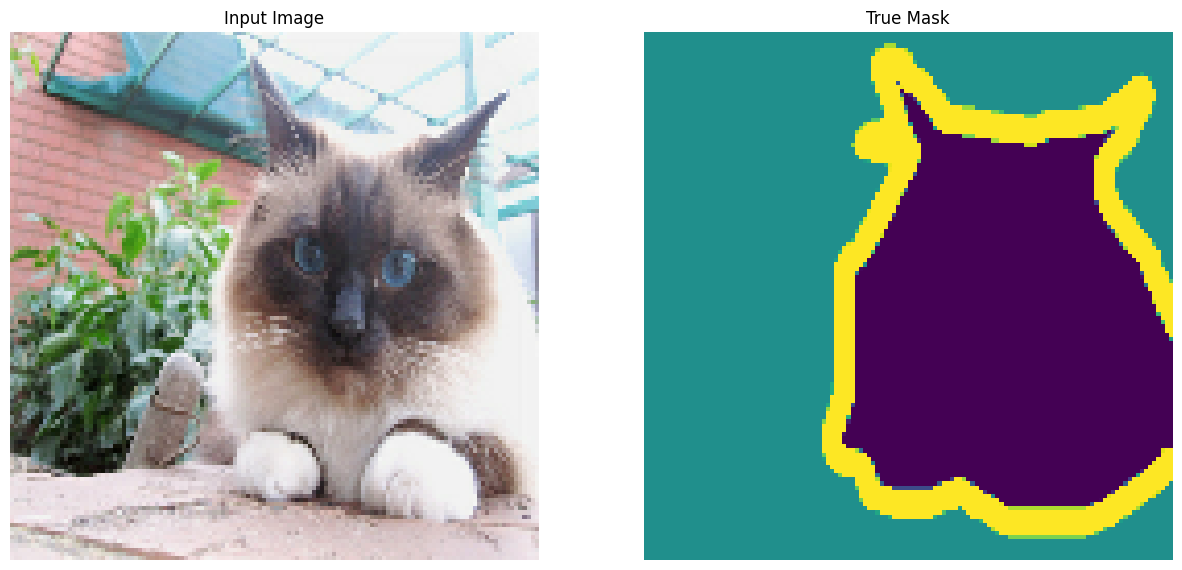

In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


# Выбор индекса изображения из обучающего набора
chosen_index = 10  # Укажите индекс нужного изображения

# Получение выбранного изображения и его маски
for idx, (image, mask) in enumerate(train):
    if idx == chosen_index:
        sample_image, sample_mask = image, mask
        break

# Проверка и приведение размера выбранного изображения, если необходимо
desired_image_shape = (128, 128)  # Желаемый размер изображения
if sample_image.shape[:2] != desired_image_shape:
    sample_image = tf.image.resize(sample_image, desired_image_shape)
    sample_mask = tf.image.resize(sample_mask, desired_image_shape)

# Вывод выбранного изображения и его маски
display([sample_image, sample_mask])

In [15]:
# Количество каналов в выходных данных
OUTPUT_CHANNELS = 3

# Загрузка предварительно обученной модели MobileNetV2 без верхних слоев
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)


# Имя слоев для использования их активаций
layer_names = [
    "block_1_expand_relu",  # 64x64
    "block_3_expand_relu",  # 32x32
    "block_6_expand_relu",  # 16x16
    "block_13_expand_relu",  # 8x8
    "block_16_project",  # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Создание модели для извлечения признаков
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

# Слои для апсемплинга
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),  # 32x32 -> 64x64
]


def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Прохождение данных через модель с уменьшением размерности
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Увеличение размерности и установление связей с пропущенными данными
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # Последний слой модели
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding="same")  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


# Создание маски из предсказанных данных
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


# Отображение предсказаний
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])


# Callback для отображения прогресса
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print(f"\nПример предсказания после эпохи {epoch + 1}\n")

In [16]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(
    optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

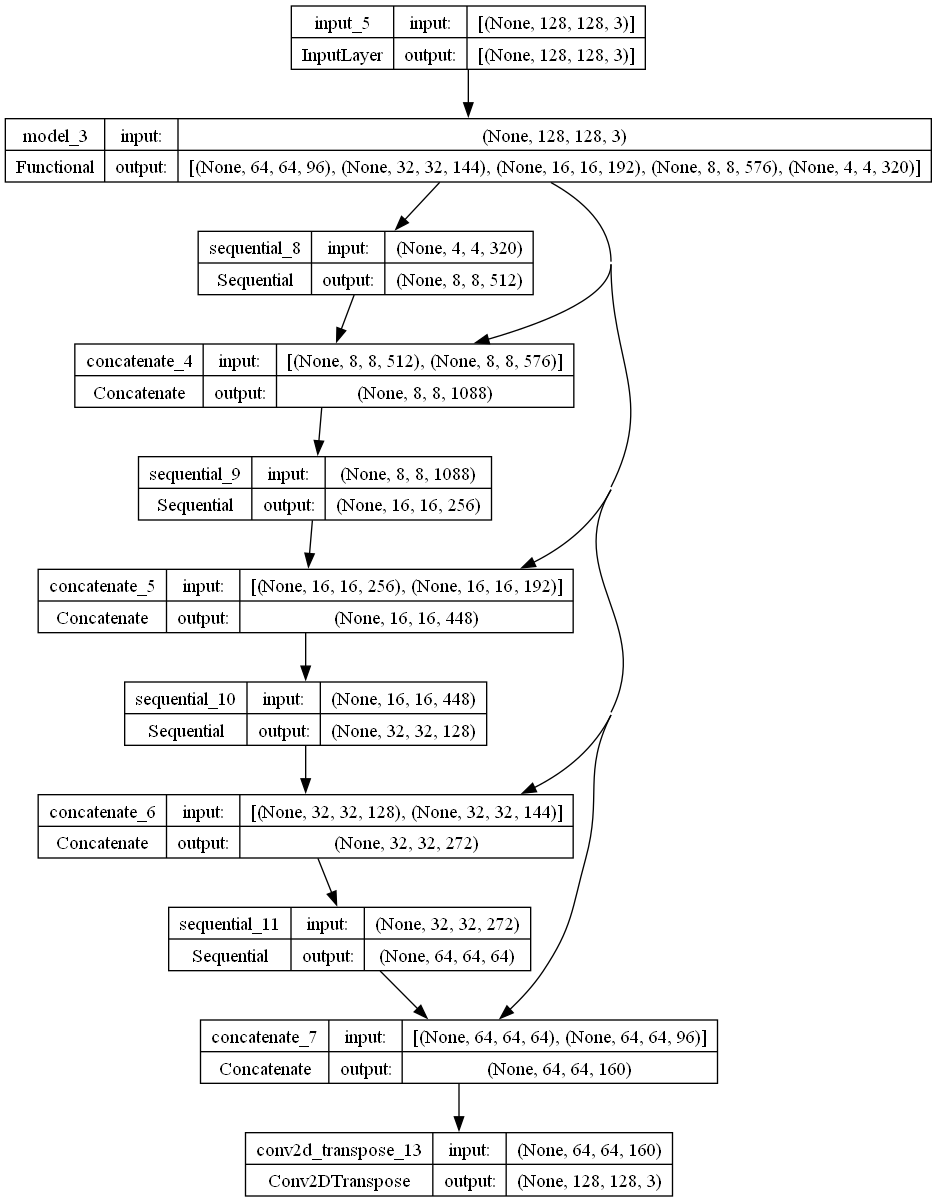

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

1/1 [==============================] - 0s 86ms/step


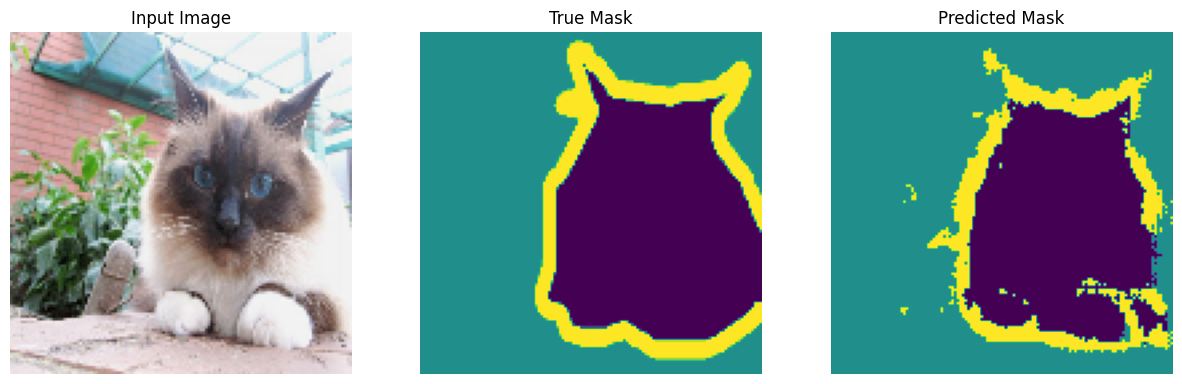


Пример предсказания после эпохи 5

57/57 [==============================] - 205s 4s/step - loss: 0.2561 - accuracy: 0.8924 - val_loss: 0.2906 - val_accuracy: 0.8811


In [18]:
EPOCHS = 5  # количество эпох обучения
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["test"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[DisplayCallback()],
)

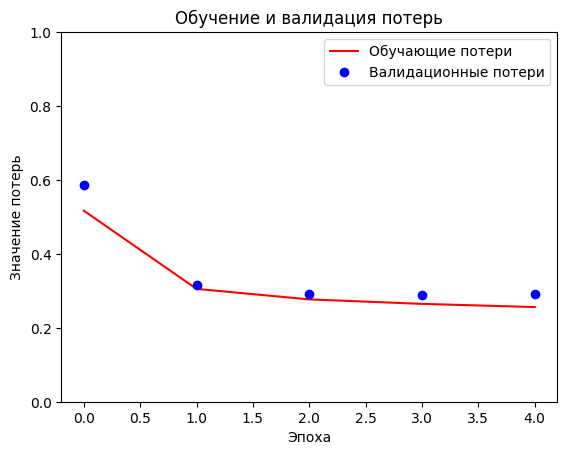

In [35]:
loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, "r", label="Обучающие потери")
plt.plot(epochs, val_loss, "bo", label="Валидационные потери")
plt.title("Обучение и валидация потерь")
plt.xlabel("Эпоха")
plt.ylabel("Значение потерь")
plt.ylim([0, 1])
plt.legend()
plt.show()

In [27]:
def show_random_predictions(test_dataset, num=1):
    # Конвертировать test_dataset в список изображений
    images = list(test_dataset)

    # Выбрать случайные изображения из списка
    random_images = random.sample(images, num)

    # Отображаем случайные изображения
    for image, mask in random_images:
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

2/2 [==============================] - 2s 843ms/step


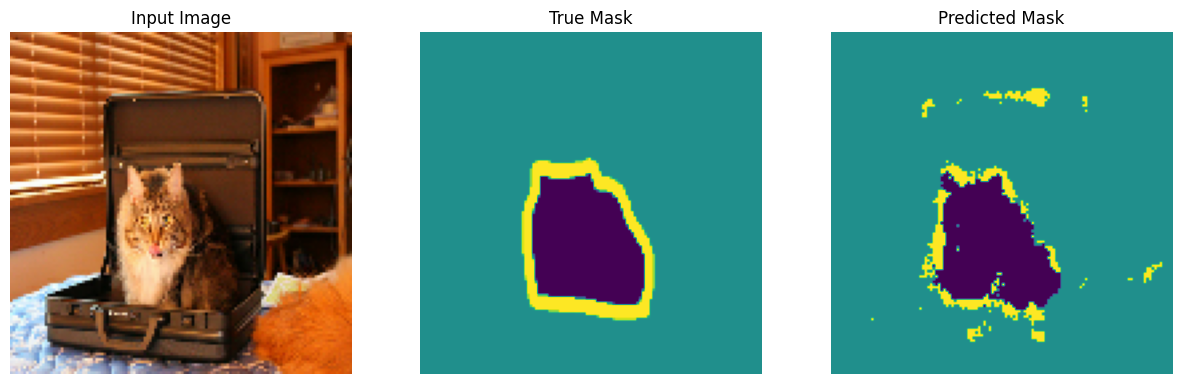

2/2 [==============================] - 2s 865ms/step


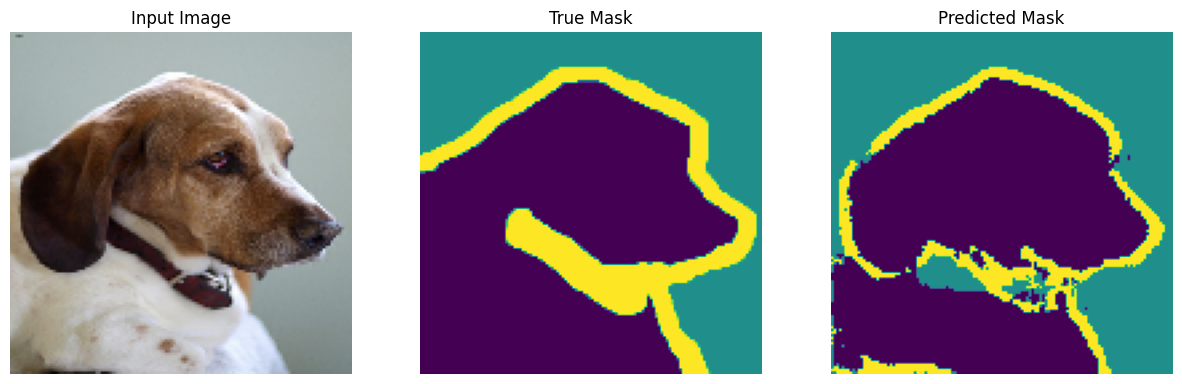

2/2 [==============================] - 2s 948ms/step


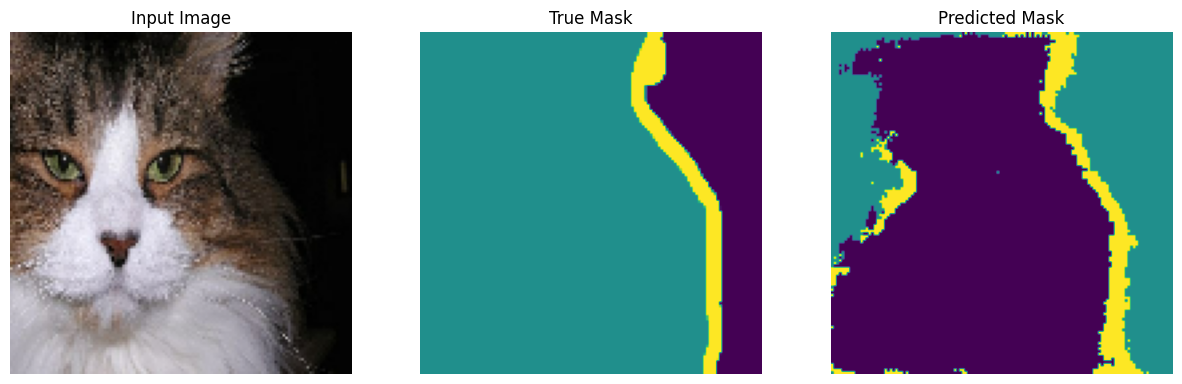

In [32]:
show_random_predictions(test_dataset, 3) # Случайные предсказания